In [13]:
import pandas as pd
import math
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt

from scipy.stats import expon #need to use scipy stats for scale
from scipy.stats import binom
from scipy.interpolate import interp1d #pre written interpolation function

In [14]:
#load data from schedule/coefficients
coef = pd.read_csv('coef.csv',index_col=0)
schedule = pd.read_csv('schedule.csv')

#set up global variables
TIME = 20
BETA = .99

SIGMA, GAMMA, PHI, DELTA, SIGMA_R, MU,THETA = coef['france']
NSIM = 200

sched_1 =  np.array(schedule['sched_1'])
sched_2 =  np.array(schedule['sched_2'])

In [15]:
def memoize_value(sched, l, max_r, grid):
    """memioze the value funcion l periods into the past"""
    
    #set up states
    states = np.array(range(0,max_r,grid))
    
    if l == TIME: #if we are in the last period
        V = [np.maximum( 0, states - sched[l-2])]
        return np.array(V)
        
    elif l >= 2 and l < 20:
        
        #calculate the value function this period (and interpolate)
        V = memoize_value(sched,l+1,max_r, grid)
        V0 = interp1d(states, V[0],fill_value="extrapolate")
        
        #set up r_a as a 3d array to use with simulations
        ra = states.reshape(int(max_r/grid),1)
        ra = np.tile(ra, (1,NSIM))
        
        #caclulate value of innovation 'z' for each state in each simulation
        sigma_l = SIGMA * PHI**(l-1)
        z_sim = expon(loc= -GAMMA, scale= sigma_l ).rvs(size=(1,NSIM))
        z_sim = np.tile(z_sim, (int(max_r/grid) ,1)) #the same draws for each state
        
        #set up cutoff pr for binomial draws
        cutoff_pr = np.exp(-THETA*ra)
        
        #set up uniform draws to compare with cutoff
        binom_draws = np.random.uniform(0, 1, size=(1,NSIM))
        binom_draws = np.tile(binom_draws, ( int(max_r/grid) ,1)) #the same draws
        binom_draws =  (binom_draws > cutoff_pr).astype(int)
        
        #set up value of ra in next period
        ra_next = np.maximum( DELTA*ra, z_sim)
        ra_next = binom_draws*ra_next
        
        #calculate the expected value function next period
        EV_next = V0(ra_next)
        EV_next = EV_next.mean(axis=1)
        
        #calculate the value funciton this period, uisn g
        V_update = np.maximum( 0, states + BETA*EV_next - sched[l-2]).reshape(1,int(max_r/grid))
        V = np.concatenate( (V_update , V), axis=0)
        return V
    else:
        print('Index out of Bounds')
        return None


In [16]:


def find_cutoffs(V):
    """find the sequence of cutoff values"""
    cutoffs = []
    
    for l in range(len(V)):
        for r in range(len(V[l])):
            if V[l][r] > 0:
                cutoffs.append((r)*GRID)
                break
    return cutoffs



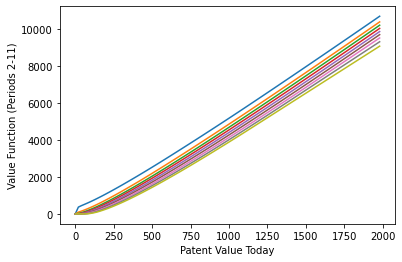

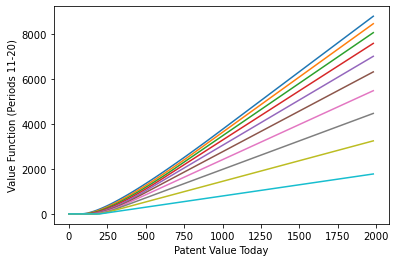

In [17]:


SCHED =  np.array(schedule['sched_1'])
MAX_R = 2000
GRID = 20
STATES = np.array(range(0,MAX_R,GRID))

#graph value function - Schedule 1
V =  memoize_value(sched_1,2,MAX_R,GRID)

#period's 1-9
fig = plt.figure()
for i in range(9):
    plt.plot(STATES, V[i])
    
plt.xlabel('Patent Value Today')
plt.ylabel('Value Function (Periods 2-11)')

#periods 9-18
fig = plt.figure()
for i in range(9,19):
    plt.plot(STATES, V[i])
    
plt.xlabel('Patent Value Today')
plt.ylabel('Value Function (Periods 11-20)');

